In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

* The CSV files are located in the root of the directory containing the iPython Notebook
* To avoid any sort of issues realted to improper column names, some of the field names have been altered
* The 'date' field is currently is of type 'object' and has been converted into 'datetime'

In [3]:
monthly_data = pd.read_csv("Monthly_data_cmo.csv")
cmo_msp_mandi = pd.read_csv("CMO_MSP_Mandi.csv")

monthly_data.rename(columns={'Commodity':'commodity','Year':'year','Month':'month'},inplace=True)
monthly_data['date'] =  pd.to_datetime(monthly_data['date']).dt.strftime('%Y-%m')

* The two CSV files represent time series data
* We would deal with the dataframe containing only those 'years' which are present in both the datasets

In [4]:
available_year_data = sorted(list(set(monthly_data['year'].unique()).intersection(set(cmo_msp_mandi['year'].unique()))))
print(available_year_data)

[2014, 2015, 2016]


* In the following snippent, we alter the fields to represent prices per arrived quintal
* We remove the cases where `modal_price` doesn't lie between `min_price` and `max_price`
* `min_price` would now represent minimum price per arrived quintal i.e. `min_per_quintal`
* `max_price` -> `max_per_qtl`
* `modal_price` -> `mod_per_qtl`
* The edited dataframe is called `new`

In [5]:
df = monthly_data[((monthly_data['modal_price'] <= monthly_data['max_price']) & 
                 (monthly_data['modal_price'] >= monthly_data['min_price']))]

new = df.drop(['state_name'],axis=1)

new['min_price'] = new['min_price']/new['arrivals_in_qtl']
new['max_price'] = new['max_price']/new['arrivals_in_qtl']
new['modal_price'] = new['modal_price']/new['arrivals_in_qtl']

new.rename(columns={'min_price':"min_per_qtl",},inplace=True)
new.rename(columns={'max_price':"max_per_qtl",},inplace=True)
new.rename(columns={'modal_price':"mod_per_qtl",},inplace=True)

In [90]:
new.head()

,APMC,commodity,year,month,arrivals_in_qtl,min_per_qtl,max_per_qtl,mod_per_qtl,date,district_name
0,Ahmednagar,Bajri,2015,April,79,17.797468,19.468354,18.518987,2015-04,Ahmadnagar
1,Ahmednagar,Bajri,2016,April,106,16.867925,18.160377,17.688679,2016-04,Ahmadnagar
2,Ahmednagar,Wheat(Husked),2015,April,1253,1.254589,1.508380,1.381484,2015-04,Ahmadnagar
3,Ahmednagar,Wheat(Husked),2016,April,387,4.521964,5.736434,5.165375,2016-04,Ahmadnagar
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,0.418301,0.575163,0.496732,2015-04,Ahmadnagar


`get_graph()` would be used to get series plots for each commodity from a APMC cluster

In [12]:
seasonal = []

def enter_seasonal(commodity):
    if commodity not in seasonal:
        seasonal.append(commodity)
    
def get_graph(apmc,commodity):
    seasonal = []
    seas = 0
    try:
        x_14 = new[(new['APMC']==apmc) & (new['commodity']==commodity) & (new['year']==2014)]
        x_14.sort_values(by='date').set_index('month').plot(stacked=True,kind="bar",y=['min_per_qtl','mod_per_qtl','max_per_qtl'],figsize=[15,5],title='{}-{}-2014'.format(apmc,commodity))
    except:
        seas += 1
    try:
        x_15 = new[(new['APMC']==apmc) & (new['commodity']==commodity) & (new['year']==2015)]
        x_15.sort_values(by='date').set_index('month').plot(stacked=True,kind="bar",y=['min_per_qtl','mod_per_qtl','max_per_qtl'],figsize=[15,5],title='{}-{}-2015'.format(apmc,commodity))
    except:
        seas += 1
    try:
        x_15 = new[(new['APMC']==apmc) & (new['commodity']==commodity) & (new['year']==2016)]
        x_16.sort_values(by='date').set_index('month').plot(stacked=True,kind="bar",y=['min_per_qtl','mod_per_qtl','max_per_qtl'],figsize=[15,5],title='{}-{}-2016'.format(apmc,commodity))
    except:
        seas +=1
    if(seas>1):
        enter_seasonal(commodity)
    

In [7]:
def get_all_graphs_for_apmc(apmc):
    for commodity in new.commodity.unique():
        get_graph(apmc,commodity)
    
def get_all_graphs():
    for apmc in new.APMC.unique():
        for commodity in new.commodity.unique():
            get_graph(apmc,commodity)

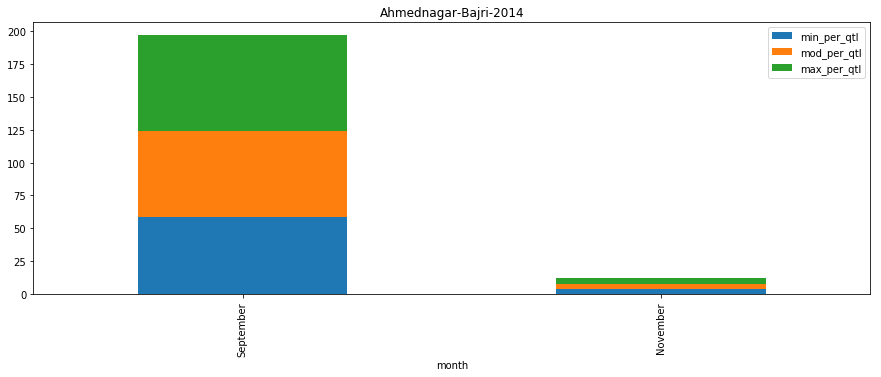

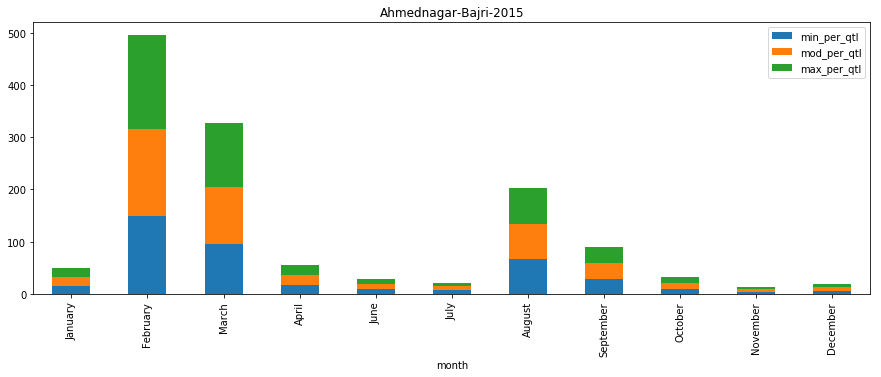

In [142]:
get_graph('Ahmednagar','Bajri')

In [91]:
new.commodity.unique()

array(['Bajri', 'Wheat(Husked)', 'Sorgum(Jawar)', 'Maize', 'Gram',
       'Horse Gram', 'Matki', 'Pigeon Pea (Tur)', 'Black Gram',
       'Castor Seed', 'Soybean', 'Jaggery', 'Lemon', 'Ginger (Fresh)',
       'Potato', 'Ladies Finger', 'Flower', 'Carrot', 'Cluster Bean',
       'Ghevda', 'Ghosali(Bhaji)', 'Mango(Raw)', 'Cucumber', 'Onion',
       'Bitter Gourd', 'Cabbage', 'Garlic', 'Math (Bhaji)', 'Capsicum',
       'Tomato', 'Brinjal', 'Tamarind', 'Tamarind Seed', 'Coriander (Dry)',
       'Green Chilli', 'Chillies(Red)', 'Mustard', 'Paddy-Unhusked',
       'Hilda', 'Chikoo', 'Cotton', 'Ground Nut Pods (Dry)', 'Pomegranate',
       'Papai', 'Melon', 'Beet Root', 'Bottle Gourd', 'Dhemse',
       'Coriander ', 'Coriander  ', 'Spinach', 'Shevga', 'Small Gourd',
       'Grapes', 'Kharbuj', 'Green Gram', 'Sunflower', 'Safflower',
       'Mango', 'Water Melon', 'Mosambi', 'Orange', 'Fenugreek', 'Cowpea',
       'Green Peas (Dry)', 'Squash Gourd', 'Maize (Corn.)', 'Chino',
       'Curry Lea

/Users/sumitsaha/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


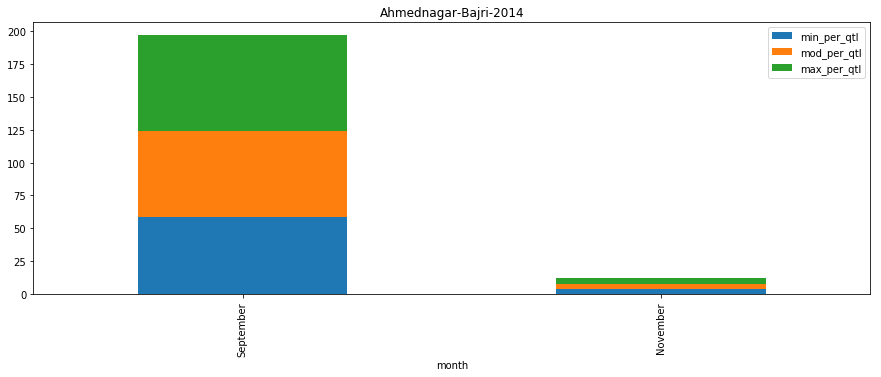

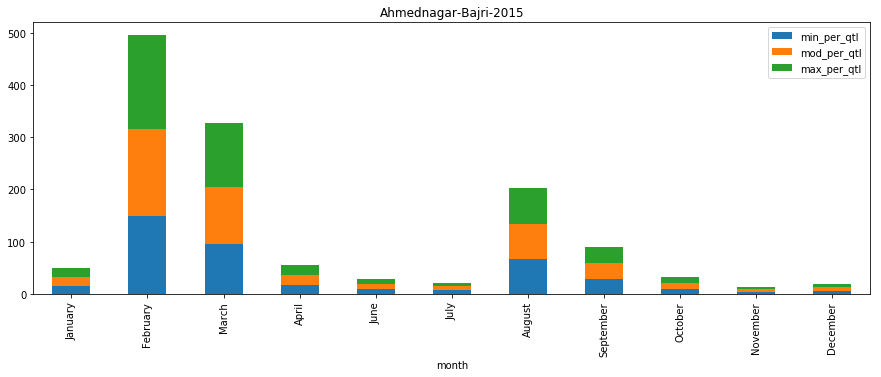

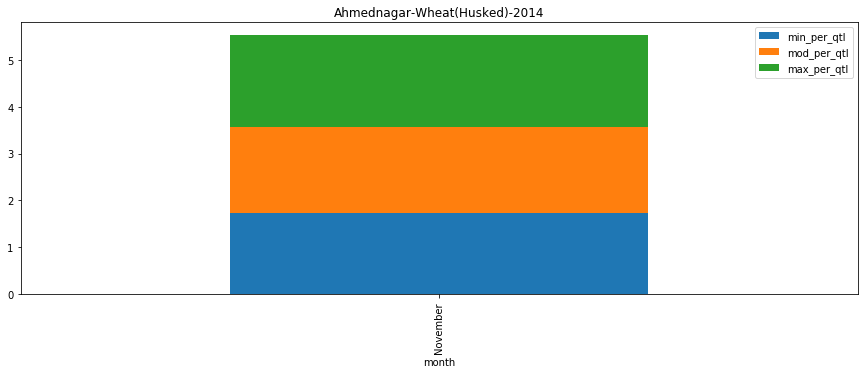

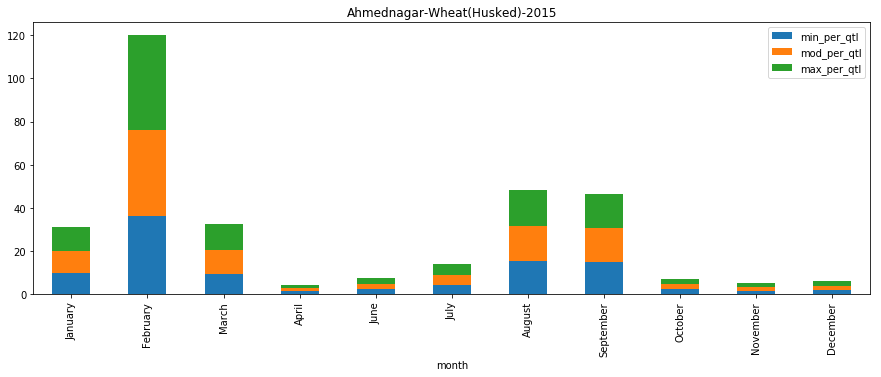

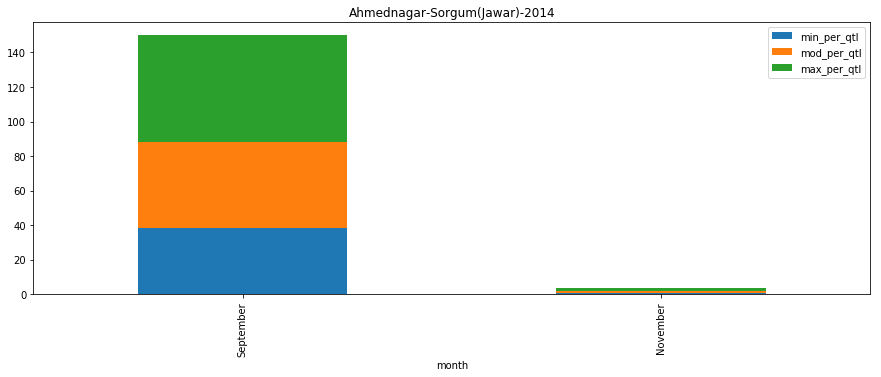

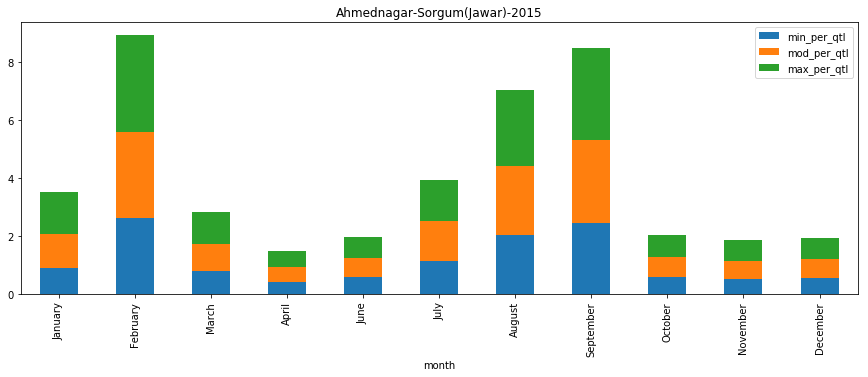

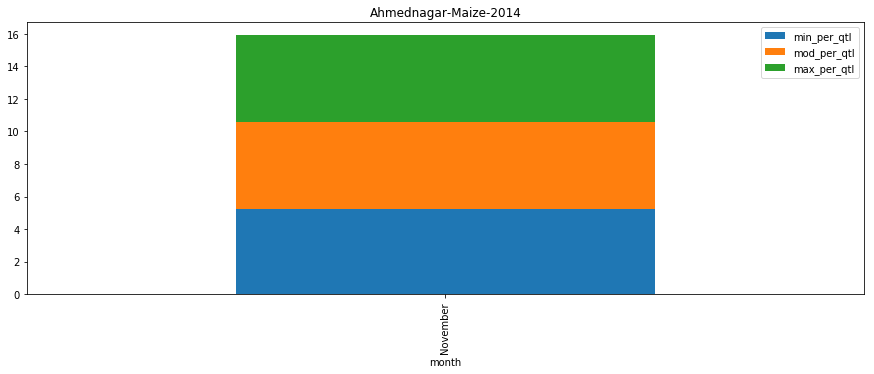

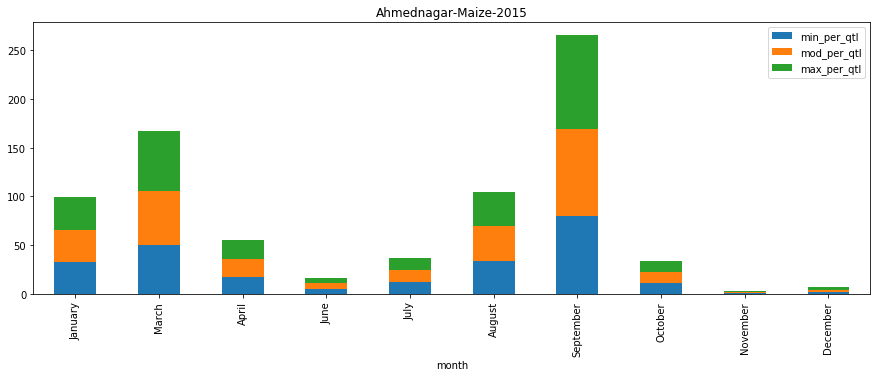

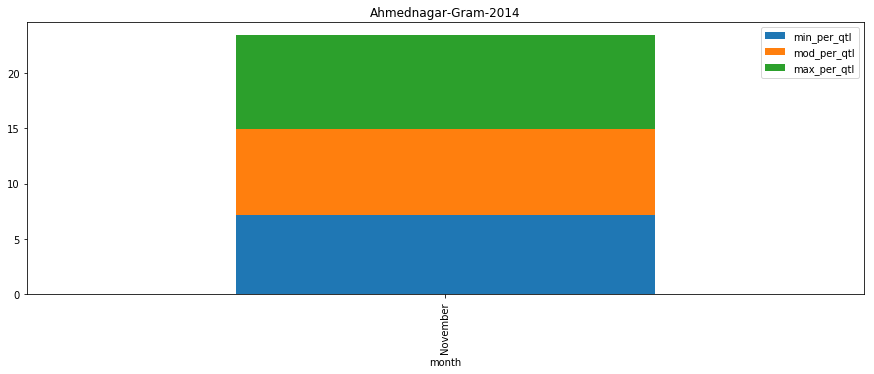

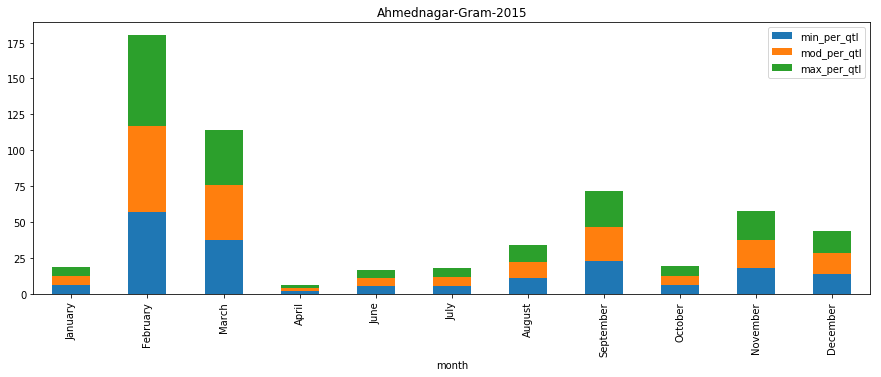

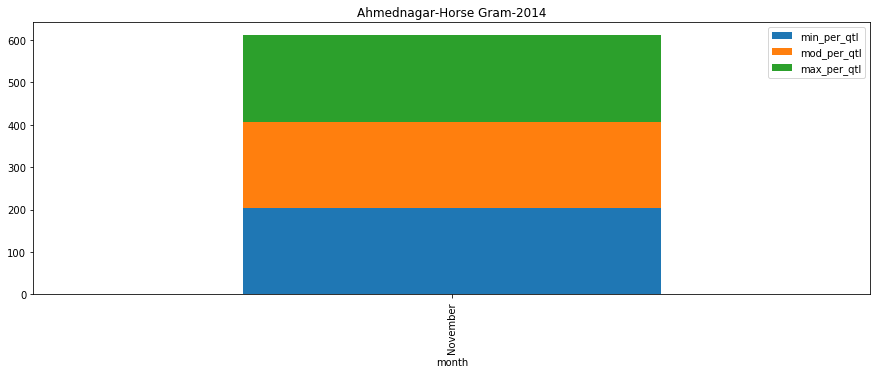

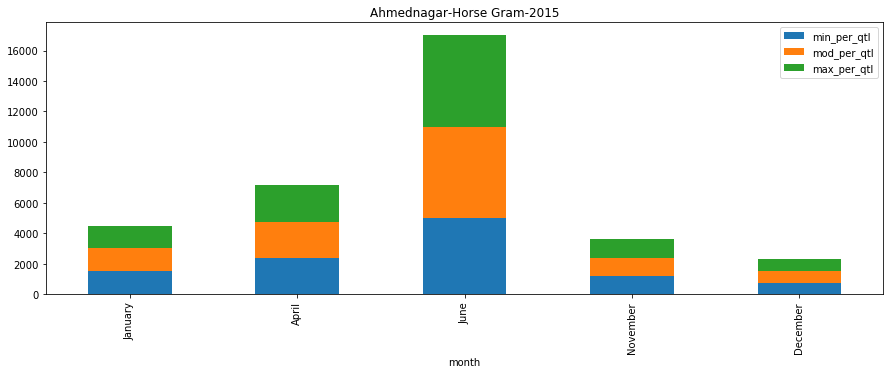

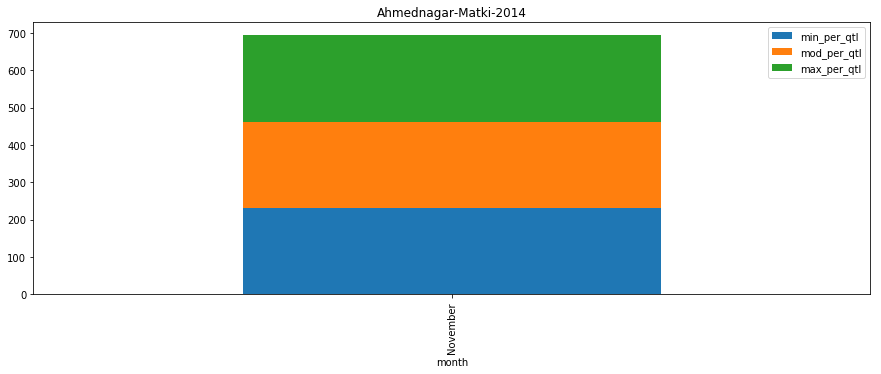

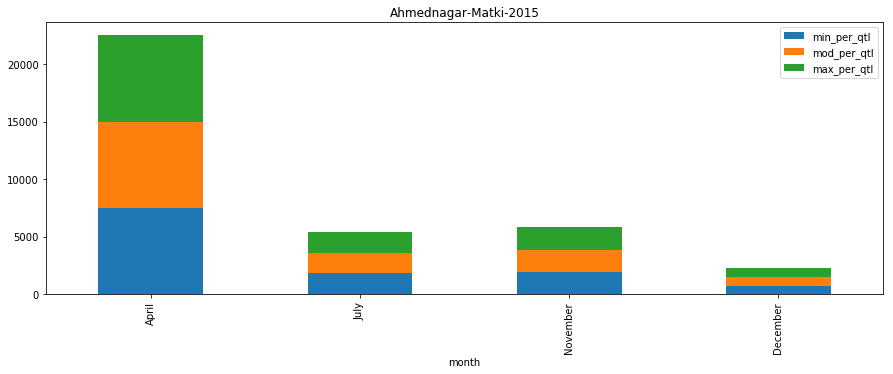

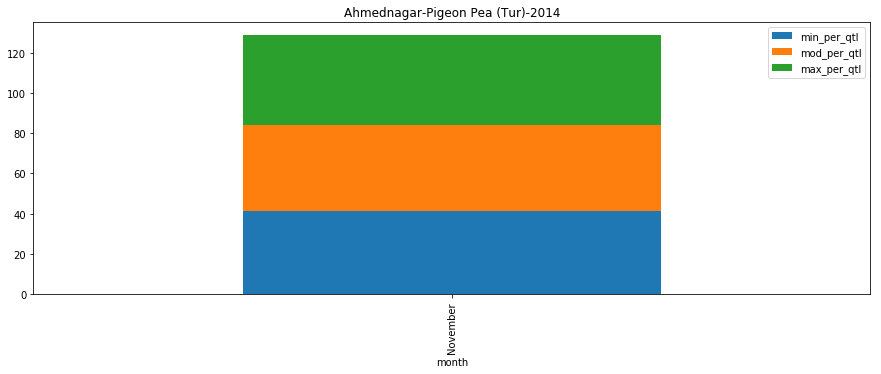

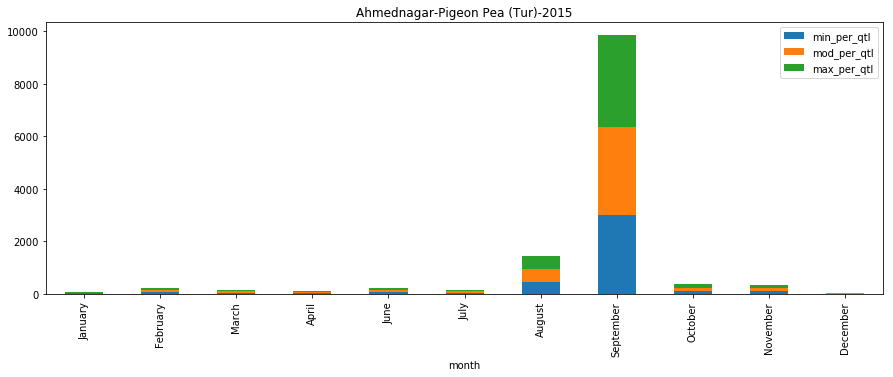

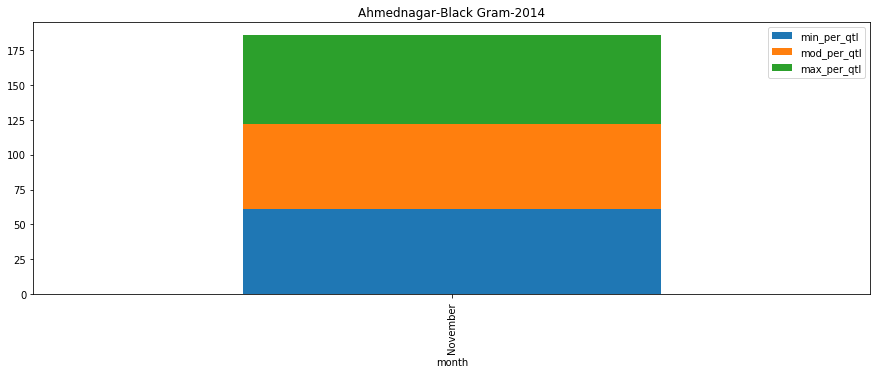

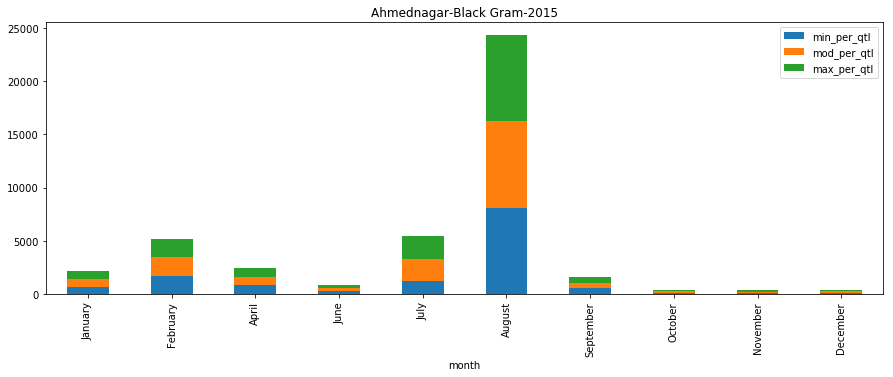

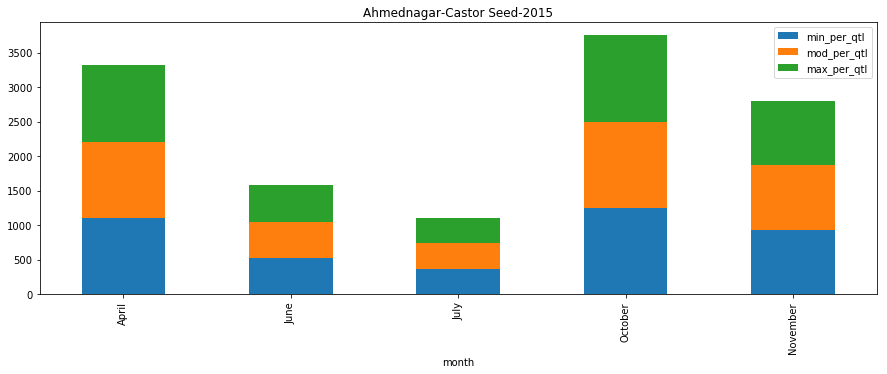

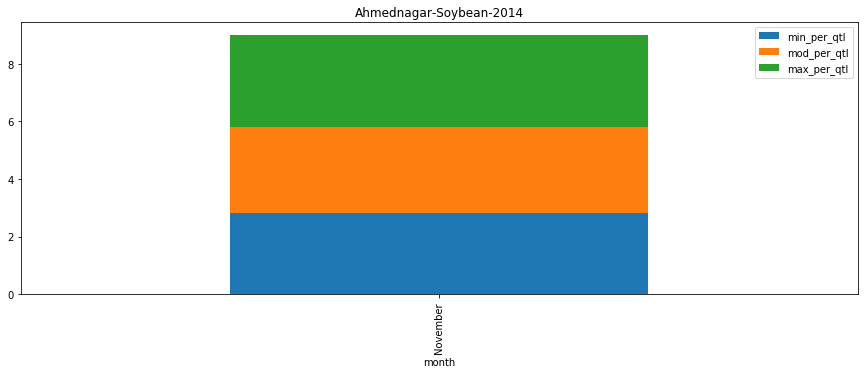

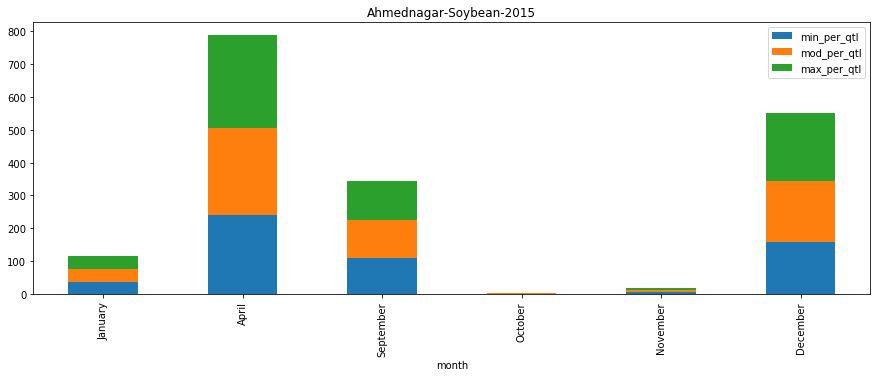

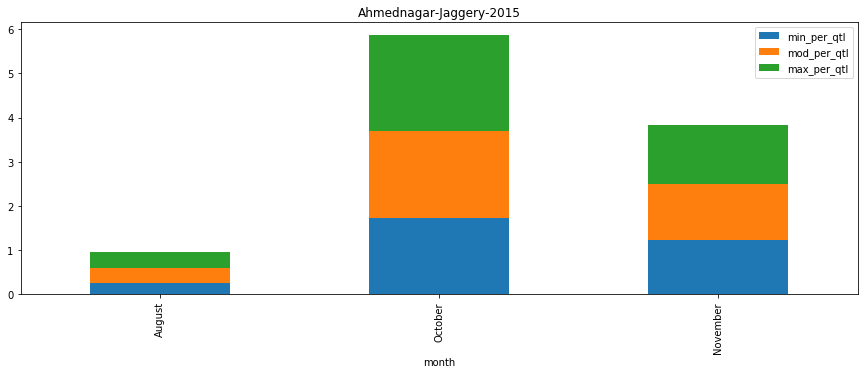

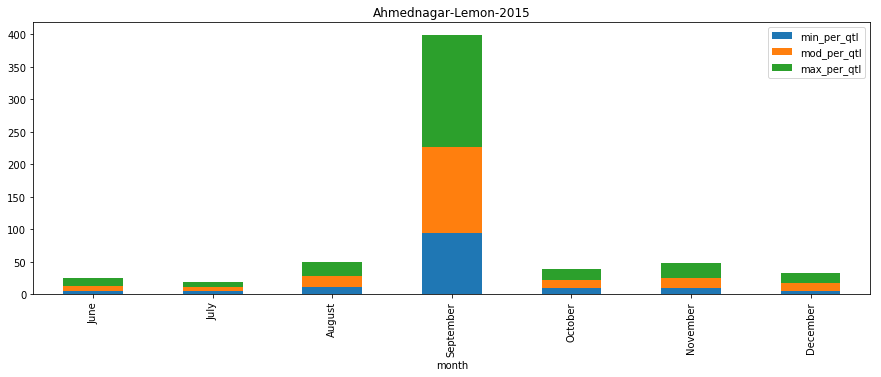

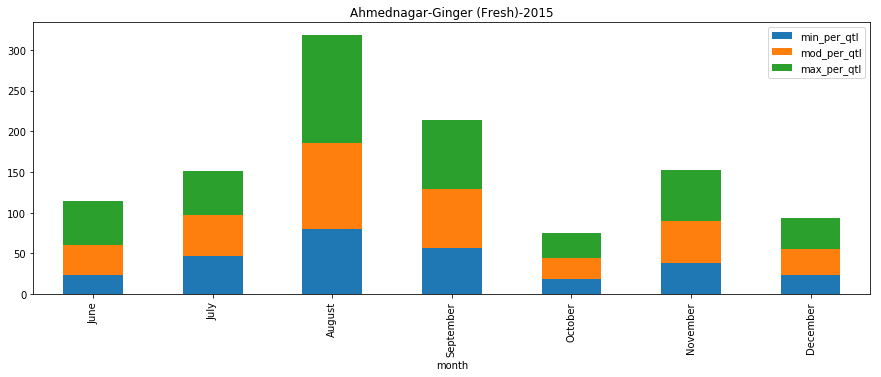

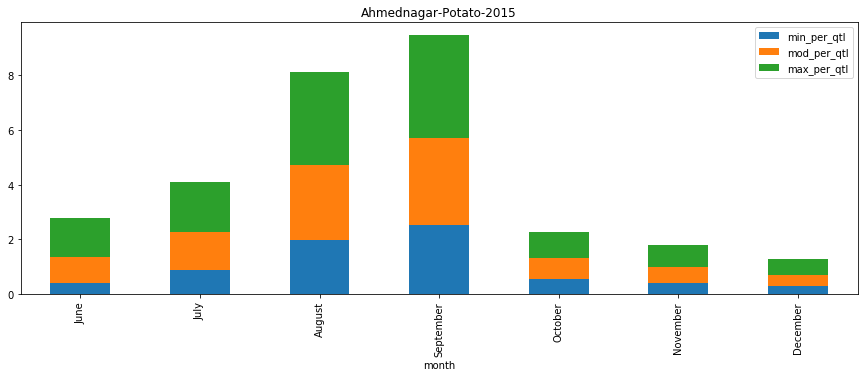

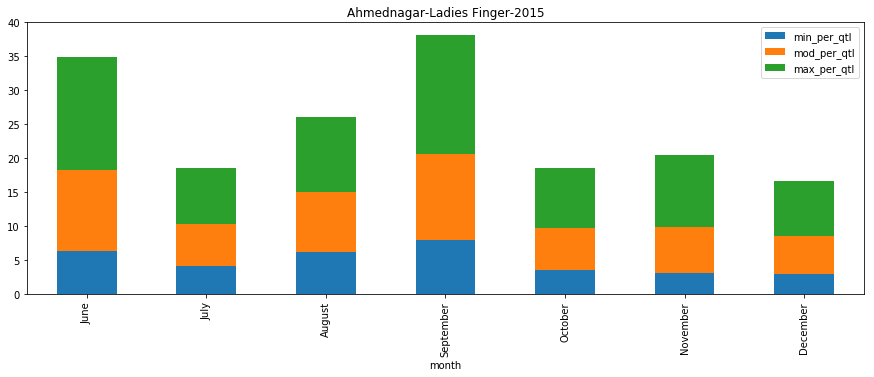

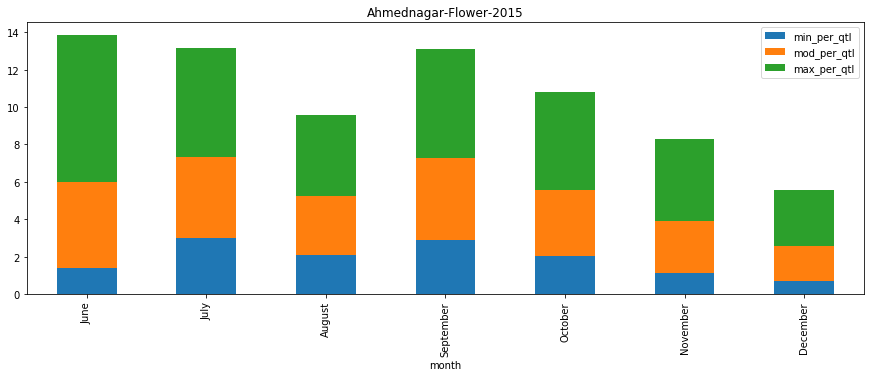

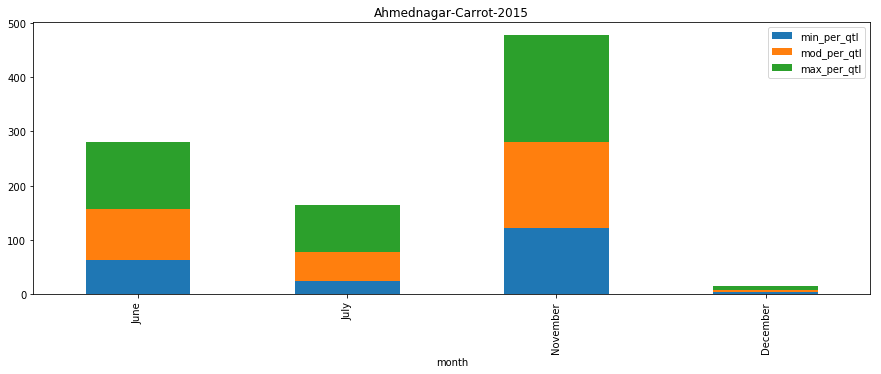

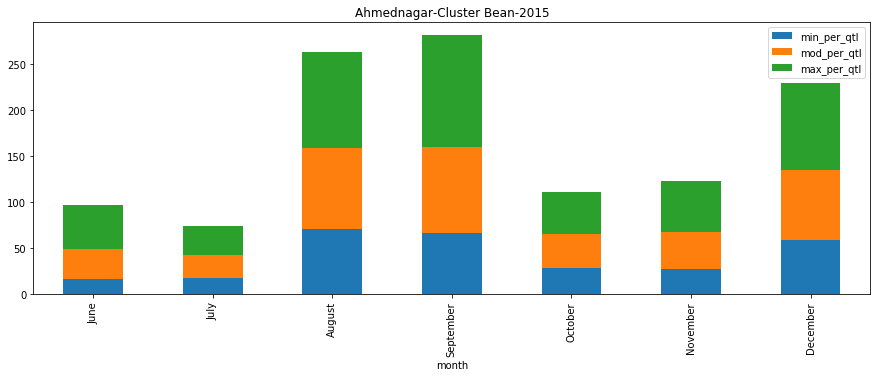

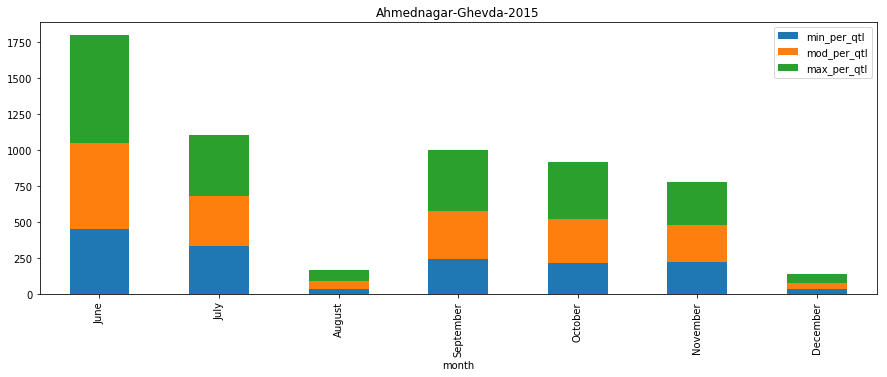

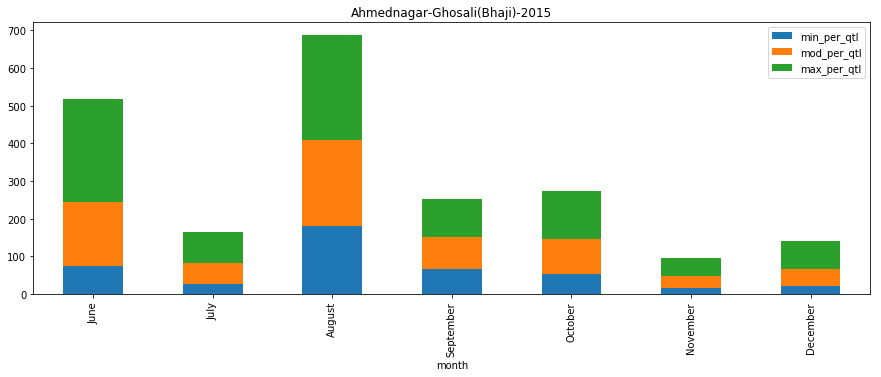

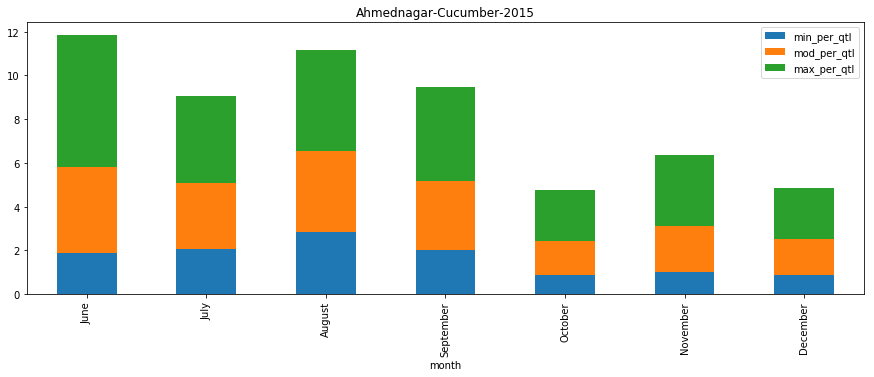

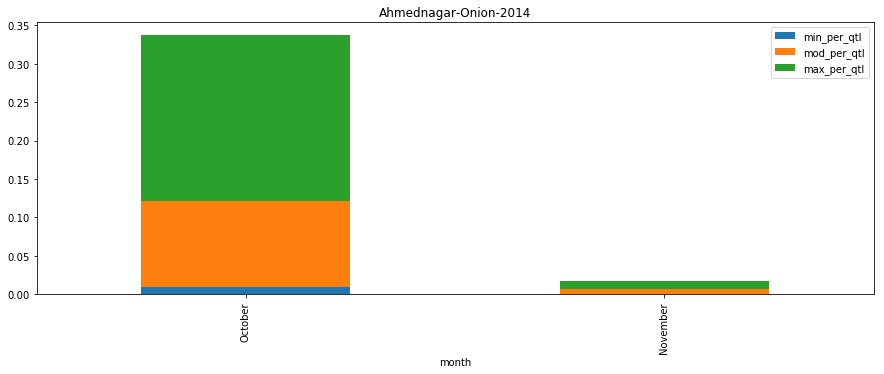

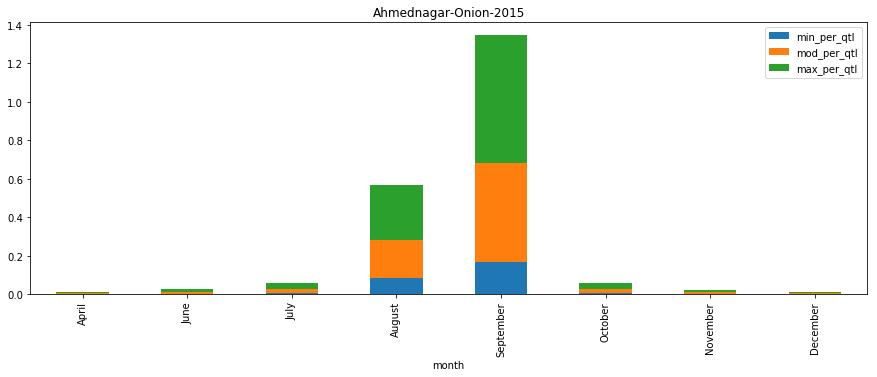

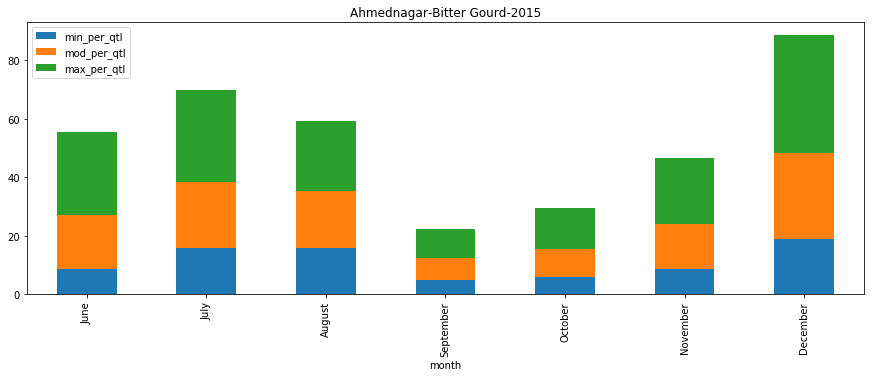

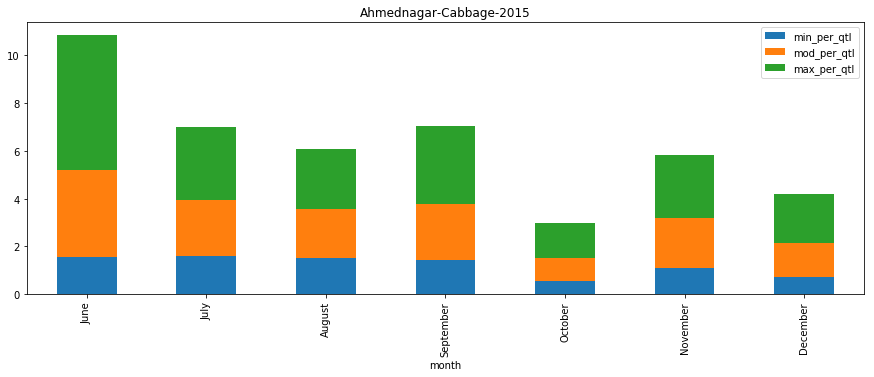

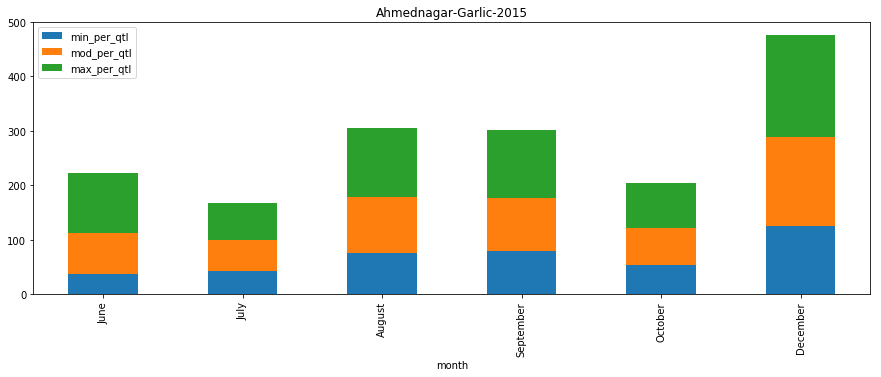

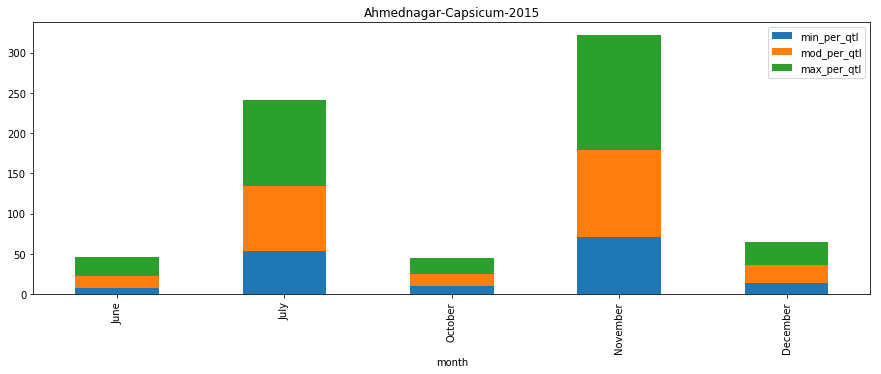

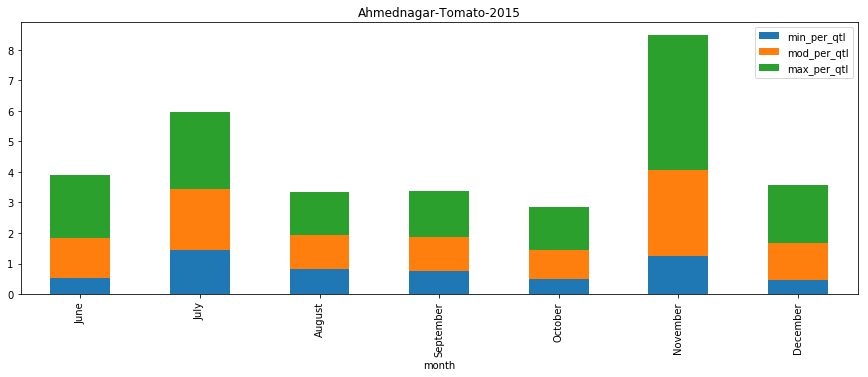

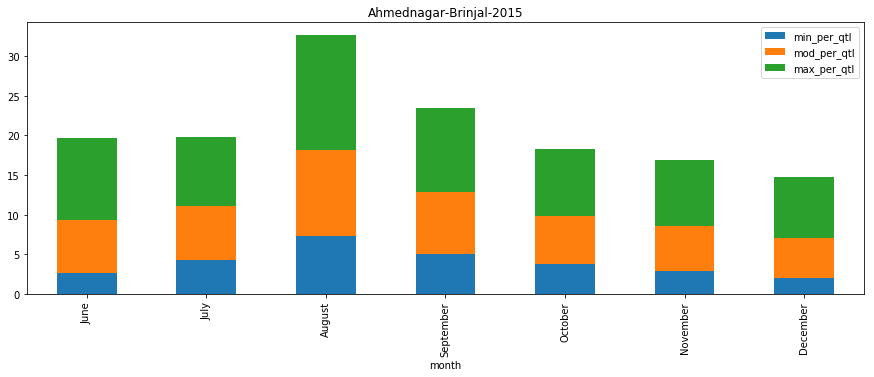

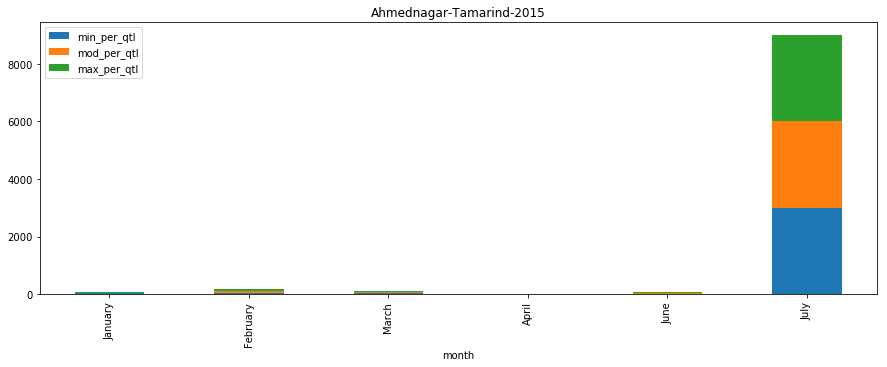

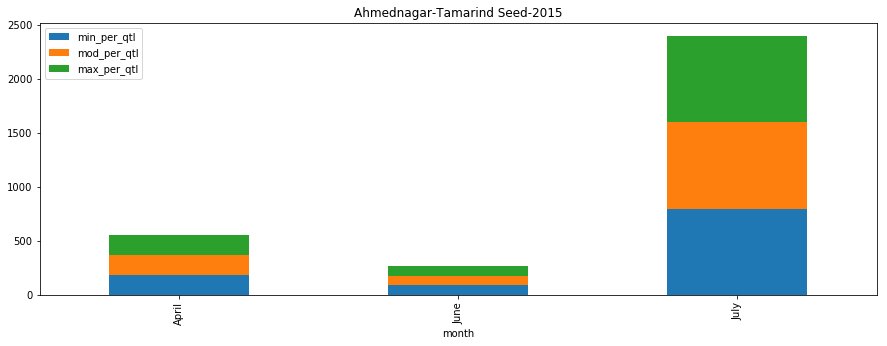

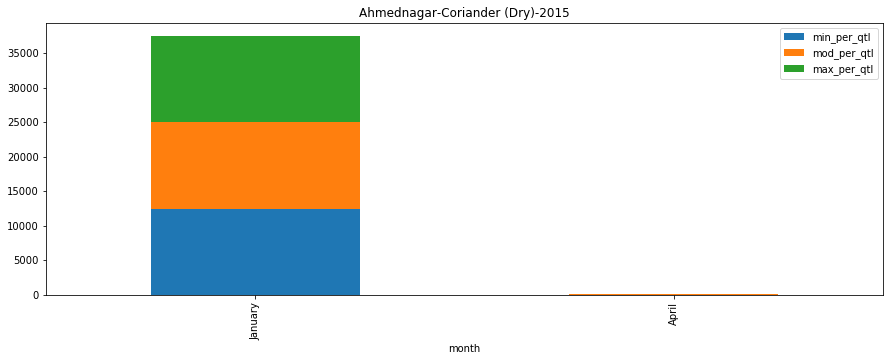

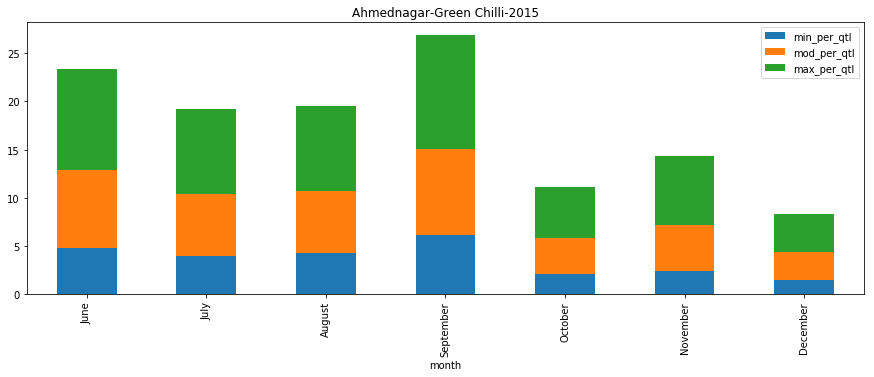

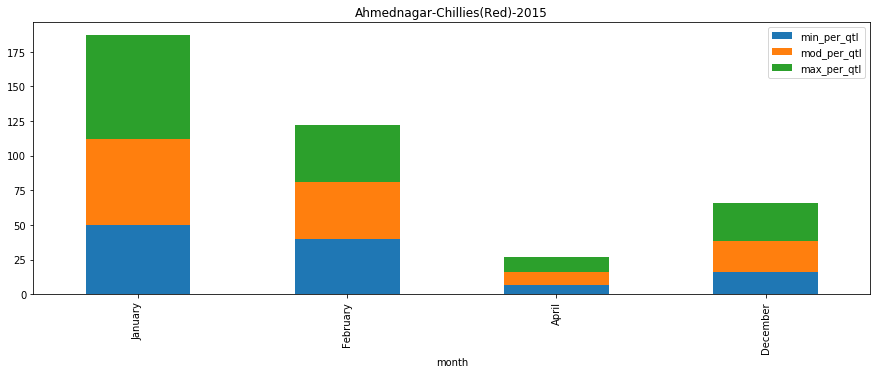

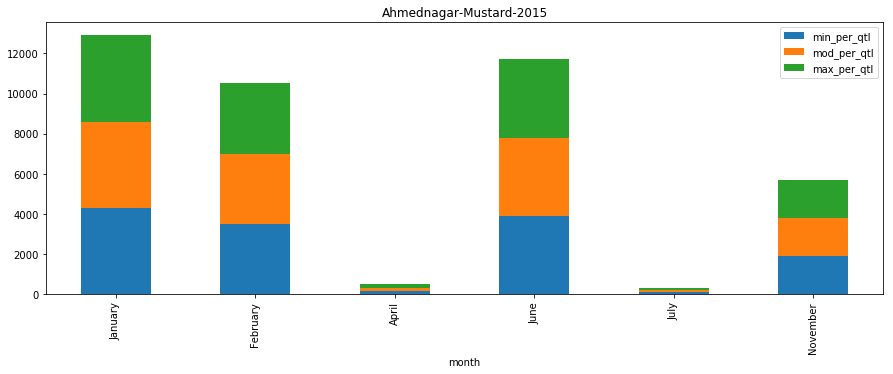

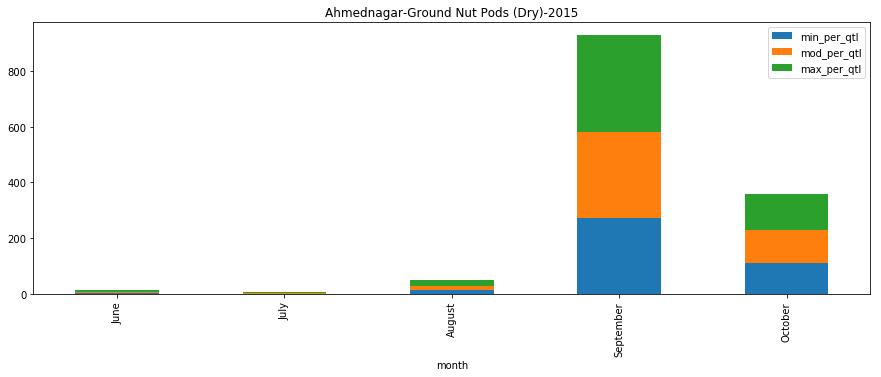

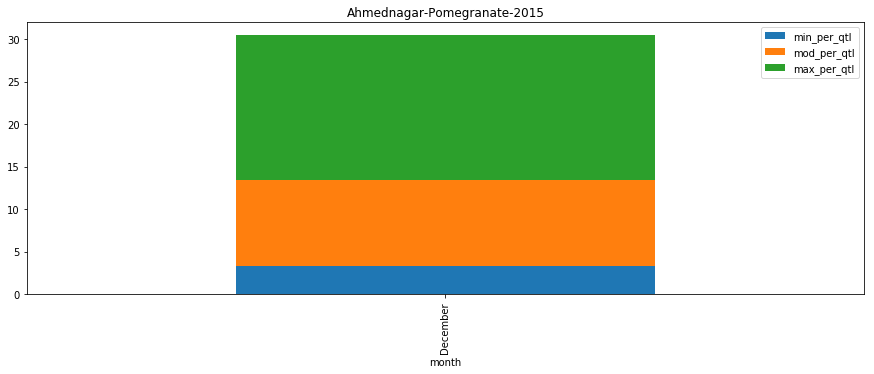

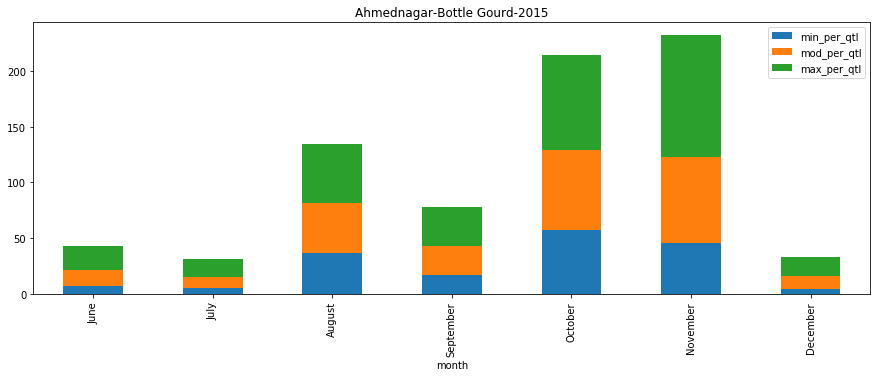

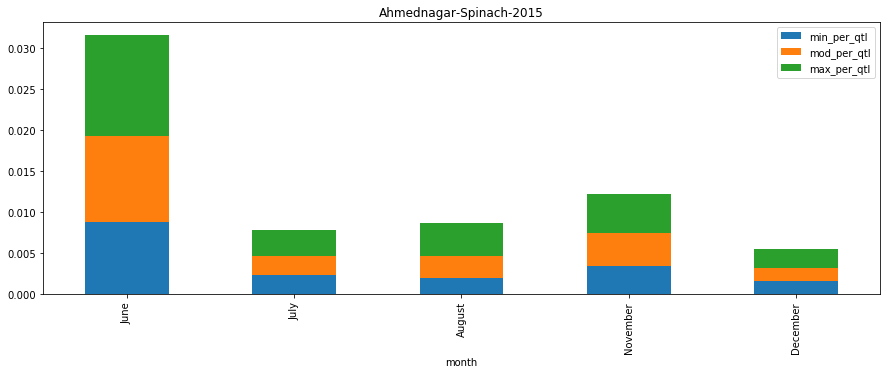

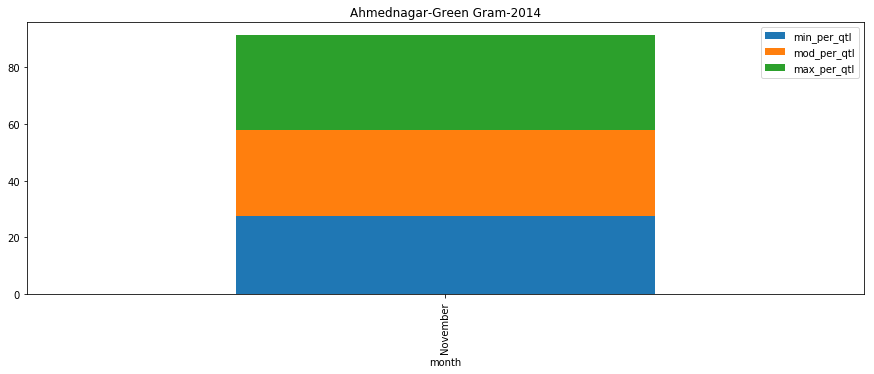

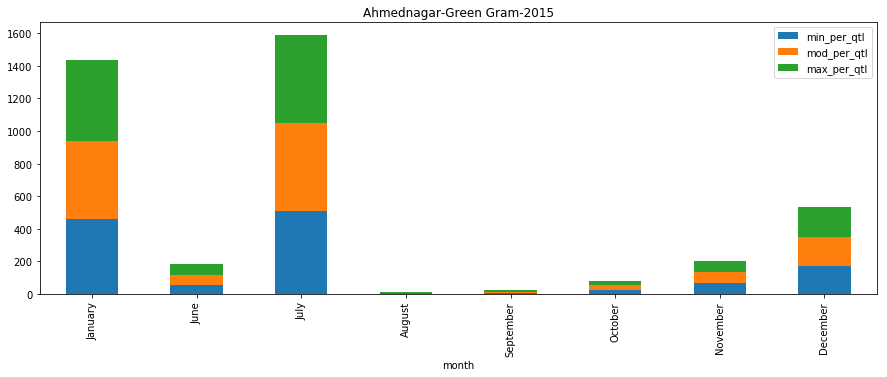

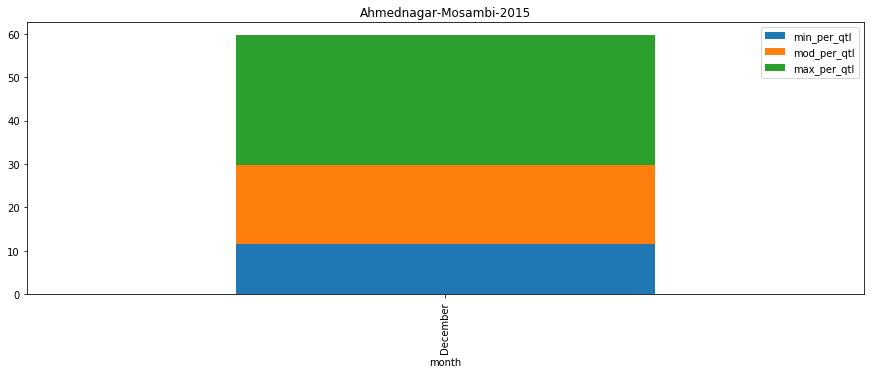

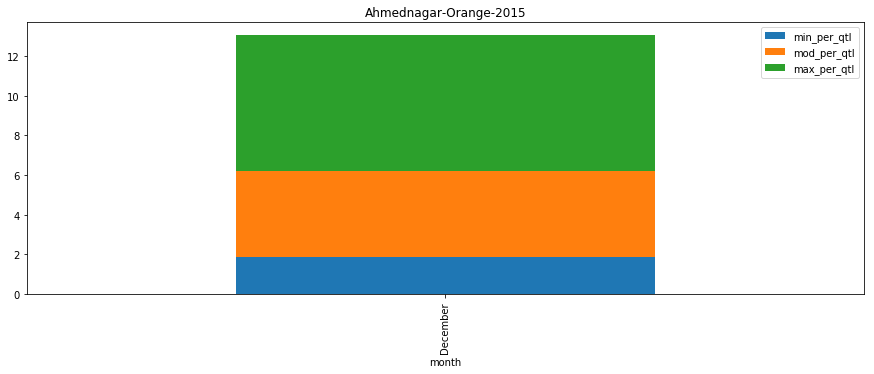

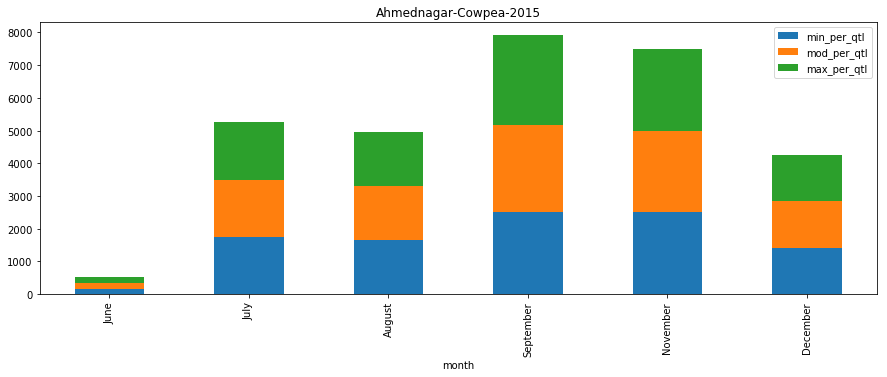

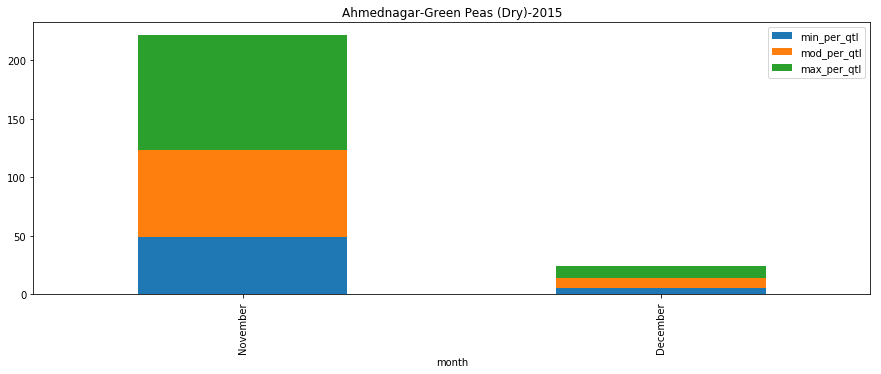

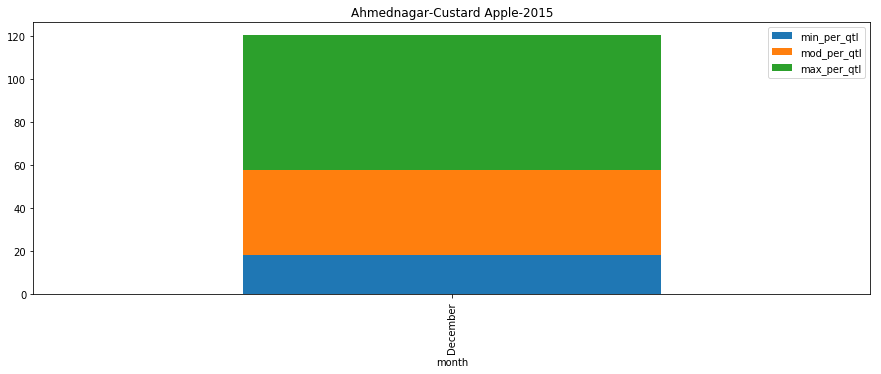

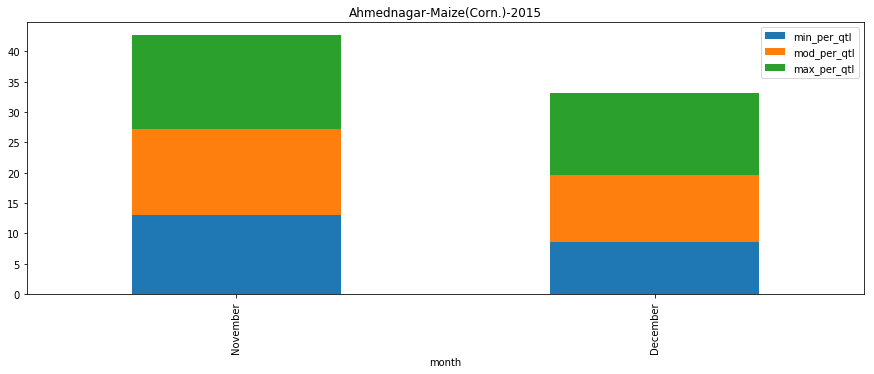

In [13]:
get_all_graphs_for_apmc('Ahmednagar')

In [14]:
seasonal

['Castor Seed',
 'Jaggery',
 'Lemon',
 'Ginger (Fresh)',
 'Potato',
 'Ladies Finger',
 'Flower',
 'Carrot',
 'Cluster Bean',
 'Ghevda',
 'Ghosali(Bhaji)',
 'Mango(Raw)',
 'Cucumber',
 'Bitter Gourd',
 'Cabbage',
 'Garlic',
 'Math (Bhaji)',
 'Capsicum',
 'Tomato',
 'Brinjal',
 'Tamarind',
 'Tamarind Seed',
 'Coriander (Dry)',
 'Green Chilli',
 'Chillies(Red)',
 'Mustard',
 'Paddy-Unhusked',
 'Hilda',
 'Chikoo',
 'Cotton',
 'Ground Nut Pods (Dry)',
 'Pomegranate',
 'Papai',
 'Melon',
 'Beet Root',
 'Bottle Gourd',
 'Dhemse',
 'Coriander ',
 'Coriander  ',
 'Spinach',
 'Shevga',
 'Small Gourd',
 'Grapes',
 'Kharbuj',
 'Sunflower',
 'Safflower',
 'Mango',
 'Water Melon',
 'Mosambi',
 'Orange',
 'Fenugreek',
 'Cowpea',
 'Green Peas (Dry)',
 'Squash Gourd',
 'Maize (Corn.)',
 'Chino',
 'Curry Leaves',
 'Sweet Potato',
 'Walvad',
 'Rice(Paddy-Hus)',
 'Custard Apple',
 'Green-Peas',
 'Maize(Corn.)',
 'Bhagar/Vari',
 'Bor',
 'Kardai',
 'Other Vegetables',
 'Radish',
 'Wal Papdi',
 'Kanda Pat',


No data for COMMODITY = Gram, APMC = Ahmednagar, YEAR = 2016


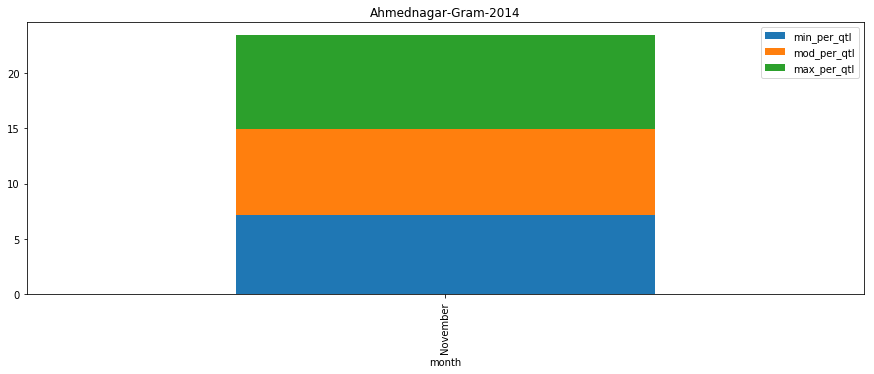

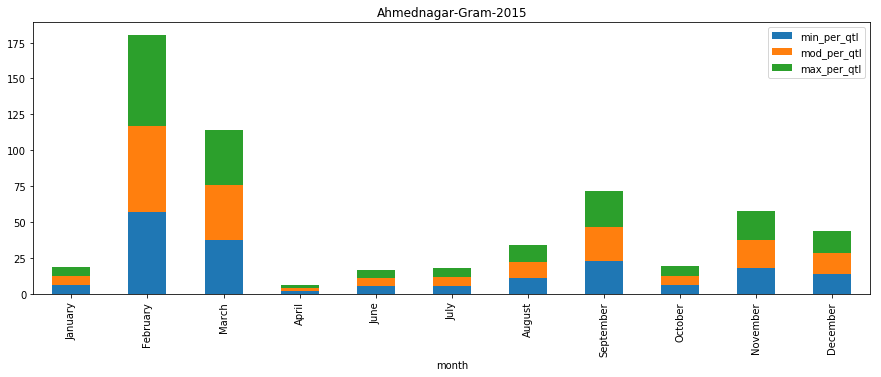

In [116]:
get_graph('Ahmednagar','Gram')

In [26]:
field_names = ['year','APMC','commodity','type','msprice','min_price','max_price','modal_price']

In [27]:
with open("cleaned_APMC.csv","w+") as file:
    writer = csv.DictWriter(file,fieldnames=field_names)
    writer.writeheader()    

In [ ]:
cmo_msp_mandi_2014 = cmo_msp_mandi[cmo_msp_mandi['year']==2014]
cmo_msp_mandi_2015 = cmo_msp_mandi[cmo_msp_mandi['year']==2015]
cmo_msp_mandi_2016 = cmo_msp_mandi[cmo_msp_mandi['year']==2016]

monthly_data_2014 = monthly_data[monthly_data['year']==2014]
monthly_data_2015 = monthly_data[monthly_data['year']==2015]
monthly_data_2016 = monthly_data[monthly_data['year']==2016]

In [ ]:
#
# Module to plot the Min, Max and Modal Prices of every city
#

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
xticks = ['January','February','March','April','May','June','July','August','September','October','November','December']

def get_apmc(data):
    return list(data.APMC.unique())
    
def get_df(data,apmc):
    df_1 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==apmc) & (monthly_data['year']==2014)]
    df_2 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==apmc) & (monthly_data['year']==2015)]
    df_3 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==apmc) & (monthly_data['year']==2016)]
    
def mini(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.min_price[df['Month']==month])[0])
        else:
            arr.append(0)
            
def maxi(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.max_price[df['Month']==month])[0])
        else:
            arr.append(0)

def modal(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.modal_price[df['Month']==month])[0])
        else:
            arr.append(0)

def arrival(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.arrivals_in_qtl[df['Month']==month])[0])
        else:
            arr.append(0)

apmc_list = get_apmc(monthly_data)

for a in apmc_list:
    min_val_3 = []
    min_val_1 = []
    min_val_2 = []
    max_val_3 = []
    max_val_1 = []
    max_val_2 = []
    modal_val_3 = []
    modal_val_1 = []
    modal_val_2 = []
    arrival_1 = []
    arrival_2 = []
    arrival_3 = []

    df_1 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2014)]
    df_2 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2015)]
    df_3 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2016)]

    mini(df_1,xticks,min_val_1)
    mini(df_2,xticks,min_val_2) 
    mini(df_3,xticks,min_val_3)
    
    maxi(df_1,xticks,max_val_1) 
    maxi(df_2,xticks,max_val_2) 
    maxi(df_3,xticks,max_val_3) 
    
    modal(df_1,xticks,modal_val_1) 
    modal(df_2,xticks,modal_val_2) 
    modal(df_3,xticks,modal_val_3) 
    
    arrival(df_1,xticks,arrival_1)
    arrival(df_2,xticks,arrival_2)
    arrival(df_3,xticks,arrival_3)
    
    plt.figure(figsize=(10,7))
    plt.xticks(x, xticks)
#     plt.plot(x,min_val_1,label="2014-Min")
#     plt.plot(x,min_val_2,label="2015-Min")
    plt.plot(x,min_val_3,label="2016-Min")
#     plt.plot(x,max_val_1,label="2014-Max")
#     plt.plot(x,max_val_2,label="2015-Max")
    plt.plot(x,max_val_3,label="2016-Max")
#     plt.plot(x,modal_val_1,label="2014-Modal")
#     plt.plot(x,modal_val_2,label="2015-Modal")
    plt.plot(x,modal_val_3,label="2016-Modal")
#     plt.scatter(x,arrival_1,label="2014-Arrival",marker="x")
#     plt.scatter(x,arrival_2,label="2015-Arrival",marker="+")
    plt.scatter(x,arrival_3,label="2016-Arrival")
    plt.legend()
    plt.suptitle(a)
    plt.show()

In [ ]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
xticks = ['January','February','March','April','May','June','July','August','September','October','November','December']

def get_apmc(data):
    return list(data.APMC.unique())

apmc_list = get_apmc(monthly_data)

def arrival(df,xticks,arr):
    for month in xticks:
        if month in list(df.Month.unique()):
            arr.append(list(df.arrivals_in_qtl[df['Month']==month])[0])
        else:
            arr.append(0)
            
for a in apmc_list:
    
    df_1 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2014)]
    df_2 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2015)]
    df_3 = monthly_data[(monthly_data['commodity']=='Bajri') & (monthly_data['APMC']==a) & (monthly_data['year']==2016)]
    
    arrival_1 = []
    arrival_2 = []
    arrival_3 = []
    
    arrival(df_1,xticks,arrival_1)
    arrival(df_2,xticks,arrival_2)
    arrival(df_3,xticks,arrival_3)
    
    plt.figure(figsize=(7,7))
    plt.xticks(x, xticks)
    plt.scatter(x,arrival_1,label="2014-Arrival",marker="x")
    plt.scatter(x,arrival_2,label="2015-Arrival",marker="+")
    plt.scatter(x,arrival_3,label="2016-Arrival")
    plt.legend()
    plt.suptitle(a)
    plt.show()

In [ ]:
hello = new[(new['min_per_qtl']!=0) | (new['max_per_qtl']!=0) | (new['mod_per_qtl']!=0)]
#hello[hello['commodity']=="Bajri"]
# xy = hello[hello['APMC']=="Akole"]
hello[hello['date']=='2015-04-01']
new = hello[(hello.commodity == "Bajri")]

new.sort_values(by='date').set_index('date').plot(stacked=True,kind="bar",y=['min_per_qtl','mod_per_qtl','max_per_qtl'],figsize=[20,10])
new.sort_values(by='date').set_index('date').plot(kind="bar",y=['arrivals_in_qtl'],figsize=[20,10])

In [ ]:
print(new.arrivals_in_qtl.max())
print(new.arrivals_in_qtl.min())
print(new.arrivals_in_qtl.mean())

norm_check = new
norm_check['arrivals_in_qtl'] = (new['arrivals_in_qtl'] - new['arrivals_in_qtl'].mean())/(new['arrivals_in_qtl'].max() - new['arrivals_in_qtl'].min())
norm_check.sort_values(by='date').set_index('date').plot(kind="bar",y=['arrivals_in_qtl'],figsize=[20,10])

In [ ]:
norm_check.sort_values(by='date')